# Flight Departure Delay Predictor

Project Goal: Develop a supervised classification model to predict whether a flight will be delayed (delay >= 15 minutes) based on weather and flight-related features. Explore both LSTM and XGBoost models to evaluate performance across temporal and tabular data.

# Data Preprocessing and Exploratory Data Analysis

Weather Data Source: https://observablehq.com/@observablehq/noaa-weather-data-by-major-u-s-city

Flight Data Source: https://www.transtats.bts.gov/ontime/Departures.aspx

Selected Data: Delta Air Lines Inc. (DL) flights departing from John F. Kennedy International Airport (JFK) from 2016 to 2021

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import glob

import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import TensorDataset, DataLoader

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
# use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.set_default_device(device)

cuda


**Data Preprocessing (Flight Data)**

* Combined months of data and sorted them by 'Scheduled departure datetime'

Raw Variables:

1. Carrier Code
2. Date (MM/DD/YYYY)
3. Flight Number
4. Tail Number
5. Destination Airport
6. Scheduled departure time
7. Actual departure time
8. Departure delay (Minutes)

Engineered Features:

1. Scheduled departure datetime

In [ ]:
# upload all raw flight csv files of a specific year under a 'flight' folder
input_path = 'flight/*.csv'
# create the file name that the combined flight data will be saved as
output_name = '2016_flight.csv'

# sort flight csv files
input_files = sorted(glob.glob(input_path))
dfs = []
# process each flight csv file
for file in input_files:
    # skip first 7 rows
    df = pd.read_csv(file, skiprows=7)
    # drop last row
    df = df.iloc[:-1]
    # create datetime feature for sorting
    df['Scheduled departure datetime'] = pd.to_datetime(df['Date (MM/DD/YYYY)'] + ' ' + df['Scheduled departure time'])
    # sort by datetime
    df = df.sort_values(by='Scheduled departure datetime')
    # append df to list
    dfs.append(df)

# combine all flight csv files
combined_file = pd.concat(dfs, ignore_index=True)
# save the combined file
combined_file.to_csv(output_name, index=False)

combined_file.info()
combined_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30263 entries, 0 to 30262
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Carrier Code                  30263 non-null  object        
 1   Date (MM/DD/YYYY)             30263 non-null  object        
 2   Flight Number                 30263 non-null  float64       
 3   Tail Number                   30263 non-null  object        
 4   Destination Airport           30263 non-null  object        
 5   Scheduled departure time      30263 non-null  object        
 6   Actual departure time         30263 non-null  object        
 7   Departure delay (Minutes)     30263 non-null  float64       
 8   Scheduled departure datetime  30263 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 2.1+ MB


,Carrier Code,Date (MM/DD/YYYY),Flight Number,Tail Number,Destination Airport,Scheduled departure time,Actual departure time,Departure delay (Minutes),Scheduled departure datetime
0,DL,01/01/2016,446.0,N900PC,ATL,06:00,05:59,-1.0,2016-01-01 06:00:00
1,DL,01/01/2016,462.0,N37700,SEA,07:00,06:59,-1.0,2016-01-01 07:00:00
2,DL,01/01/2016,420.0,N712TW,SLC,07:00,07:06,6.0,2016-01-01 07:00:00
3,DL,01/01/2016,2217.0,N374DA,SJU,07:00,06:57,-3.0,2016-01-01 07:00:00
4,DL,01/01/2016,2825.0,N396DA,MIA,07:00,07:00,0.0,2016-01-01 07:00:00


**Data Concatenation**

* Concatenated years of data



In [ ]:
# upload csv files under a 'files' folder
path = 'files/*.csv'

# edit saved_path, which is the file name that the data will be saved as
saved_path = '2016-2021_weather.csv'

# load and sort csv files
csv_files = sorted(glob.glob(path))
dfs = []

# process each csv
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)

# combine all data
combined = pd.concat(dfs, ignore_index=True)

# save the final merged data
combined.to_csv(saved_path, index=False)

combined.head()

,station,date,air_temp,dew_temp,sea_level_pressure,wind_direction,wind_speed_rate,sky_condition,precip_1hour,precip_6hour
0,74486094789,2016-01-01,8.3,0.0,1018.9,300.0,5.1,6.0,NaN,NaN
1,74486094789,2016-01-01T01:00Z,8.3,-1.1,1019.2,310.0,4.6,NaN,0.0,NaN
2,74486094789,2016-01-01T02:00Z,7.8,-1.7,1019.3,310.0,7.2,NaN,0.0,NaN
3,74486094789,2016-01-01T03:00Z,7.2,-2.2,1019.2,320.0,7.7,8.0,0.0,NaN
4,74486094789,2016-01-01T04:00Z,6.7,-2.8,1018.9,310.0,6.7,NaN,0.0,NaN


**Data Preprocessing (Weather Data)**

1. Date Format Standardisation

*   Standardised inconsistent date formats to enable accurate time-based data manipulation

2. Feature Selection

*   Dropped irrelevant features (station)
*   Dropped features with excessive missing data (precip_6hour)

3. Handling of Missing Values

*   Set negative precipitation values to 0 (precip_1hour)
*   Filled missing numerical data using linear interpolation to preserve continuity in the time series data (air_temp, dew_temp, sea_level_pressure, wind_direction, wind_speed_rate, sky_condition, precip_1hour)

4. Addition of Time-Based Features

* Extracted time-based features to capture temporal patterns (hour_of_day, day_of_week, is_weekend, month)
* Applied cyclical encoding using sine and cosine transformations to help the models recognise continuity in the time-based patterns (hour_sin, hour_cos, dow_sin, dow_cos, month_sin, month_cos)

Raw Variables:

1. date
2. air_temp
3. dew_temp
4. sea_level_pressure
5. wind_direction
6. wind_speed_rate
7. sky_condition
8. precip_1hour
9. precip_6hour

Engineered Features:

1. datetime
2. is_weekend
3. hour_sin
4. hour_cos
5. dow_sin
6. dow_cos
7. month_sin
8. month_cos

In [ ]:
# date format standardisation function
def custom_date_parser(date_str):
    # remove leading/trailing spaces
    date_str = str(date_str).strip()
    try:
        # if format is d/m/Y
        if '/' in date_str:
            return pd.to_datetime(date_str + ' ' + '00:00:00')
        # if format is ISO 8601 with 'T' and 'Z'
        elif 'T' in date_str and 'Z' in date_str:
            return pd.to_datetime(date_str, format='%Y-%m-%dT%H:%MZ')
        # try a general conversion
        else:
            return pd.to_datetime(date_str)
    except:
        # return NaT if conversion fails
        return pd.NaT

In [ ]:
# upload raw weather csv file and edit input_path
input_path = '2016-2021_weather.csv'
# create the file name that the preprocessed weather data will be saved as
output_name = '2016-2021_weather_preprocessed.csv'

# load weather csv file
weather = pd.read_csv(input_path)

# create datetime feature
weather['datetime'] = weather['date'].apply(custom_date_parser)
# drop unnecessary columns
weather = weather.drop(columns=['date', 'station', 'precip_6hour'])
# set negative precipitation values to 0
weather['precip_1hour'] = weather['precip_1hour'].apply(lambda x: max(x, 0))
# fill missing numerical values using interpolation
interpolation_cols = ['air_temp', 'dew_temp', 'sea_level_pressure', 'wind_direction', 'wind_speed_rate', 'sky_condition', 'precip_1hour']
weather[interpolation_cols] = weather[interpolation_cols].interpolate(method='linear', limit_direction='both')
# add time-based features
weather['hour_of_day'] = weather['datetime'].dt.hour
weather['day_of_week'] = weather['datetime'].dt.dayofweek
weather['is_weekend'] = weather['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
weather['month'] = weather['datetime'].dt.month
# encode hour_of_day
weather['hour_sin'] = np.sin(2 * np.pi * weather['hour_of_day'] / 24)
weather['hour_cos'] = np.cos(2 * np.pi * weather['hour_of_day'] / 24)
# encode day_of_week
weather['dow_sin'] = np.sin(2 * np.pi * weather['day_of_week'] / 7)
weather['dow_cos'] = np.cos(2 * np.pi * weather['day_of_week'] / 7)
# encode month
weather['month_sin'] = np.sin(2 * np.pi * weather['month'] / 12)
weather['month_cos'] = np.cos(2 * np.pi * weather['month'] / 12)
# drop non-encoded features
weather = weather.drop(columns=['hour_of_day', 'day_of_week', 'month'])

# save the preprocessed weather data
weather.to_csv(output_name, index=False)

weather.info()
weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52605 entries, 0 to 52604
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   air_temp            52605 non-null  float64       
 1   dew_temp            52605 non-null  float64       
 2   sea_level_pressure  52605 non-null  float64       
 3   wind_direction      52605 non-null  float64       
 4   wind_speed_rate     52605 non-null  float64       
 5   sky_condition       52605 non-null  float64       
 6   precip_1hour        52605 non-null  float64       
 7   datetime            52605 non-null  datetime64[ns]
 8   is_weekend          52605 non-null  int64         
 9   hour_sin            52605 non-null  float64       
 10  hour_cos            52605 non-null  float64       
 11  dow_sin             52605 non-null  float64       
 12  dow_cos             52605 non-null  float64       
 13  month_sin           52605 non-null  float64   

,air_temp,dew_temp,sea_level_pressure,wind_direction,wind_speed_rate,sky_condition,precip_1hour,datetime,is_weekend,hour_sin,hour_cos,dow_sin,dow_cos,month_sin,month_cos
0,8.3,0.0,1018.9,300.0,5.1,6.000000,0.0,2016-01-01 00:00:00,0,0.000000,1.000000,-0.433884,-0.900969,0.5,0.866025
1,8.3,-1.1,1019.2,310.0,4.6,6.666667,0.0,2016-01-01 01:00:00,0,0.258819,0.965926,-0.433884,-0.900969,0.5,0.866025
2,7.8,-1.7,1019.3,310.0,7.2,7.333333,0.0,2016-01-01 02:00:00,0,0.500000,0.866025,-0.433884,-0.900969,0.5,0.866025
3,7.2,-2.2,1019.2,320.0,7.7,8.000000,0.0,2016-01-01 03:00:00,0,0.707107,0.707107,-0.433884,-0.900969,0.5,0.866025
4,6.7,-2.8,1018.9,310.0,6.7,7.333333,0.0,2016-01-01 04:00:00,0,0.866025,0.500000,-0.433884,-0.900969,0.5,0.866025


**Loading Preprocessed Data**

* Added a 'Delayed' label  to the flight data, where 'Departure delay (Minutes)' >= 15 results in a flight being classified as 'Delayed'

In [ ]:
# load csv files
flight = pd.read_csv('2016-2021_flight.csv')
weather = pd.read_csv('2016-2021_weather_preprocessed.csv')

# ensure datetime format, set as index
flight['Scheduled departure datetime'] = pd.to_datetime(flight['Scheduled departure datetime'])
flight.set_index('Scheduled departure datetime', inplace=True, drop=False)

# add 'delayed' label for classification
flight['Delayed'] = flight['Departure delay (Minutes)'].apply(lambda x: 1 if x >= 15 else 0)

# ensure datetime format, set as index
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather.set_index('datetime', inplace=True)

**Data Visualisation**

Decomposition Plot (Departure Delay Over a Month)

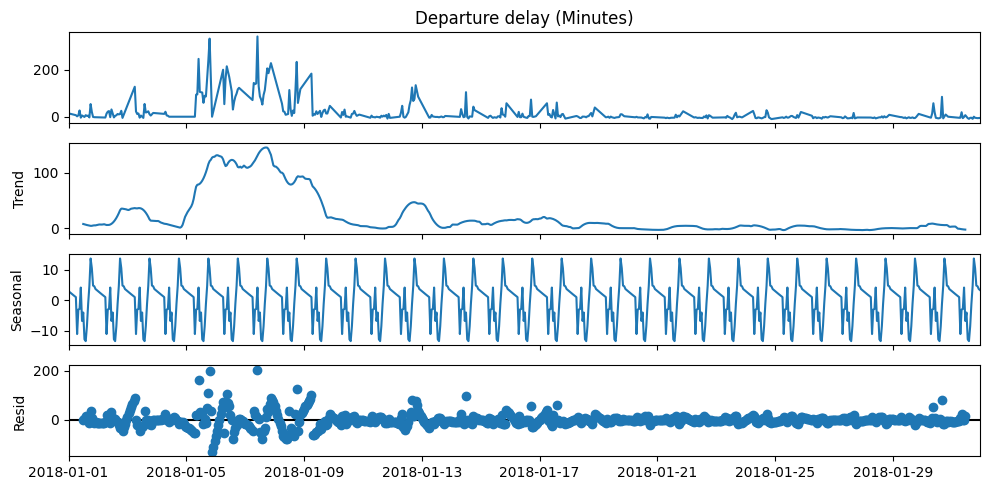

In [ ]:
# resample to hourly average delay
hourly_delay = flight['Departure delay (Minutes)'].resample('h').mean()

# fill missing values using linear interpolation
hourly_delay = hourly_delay.interpolate(method='linear')

# decompose the time series
decomposition = seasonal_decompose(hourly_delay['2018-01'], model='additive', period=24)

# plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()

Decomposition Plot (Departure Delay Over a Year)

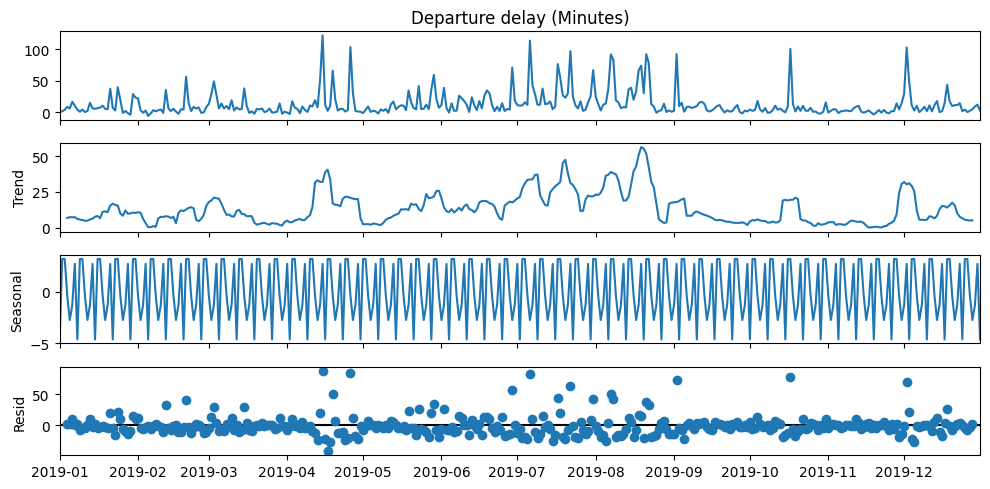

In [ ]:
# resample to daily average delay
daily_delay = flight['Departure delay (Minutes)'].resample('D').mean()

# decompose the time series
decomposition = seasonal_decompose(daily_delay['2019'], model='additive', period=7)

# plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()

Decomposition Plot (Departure Delay Over 6 Years)

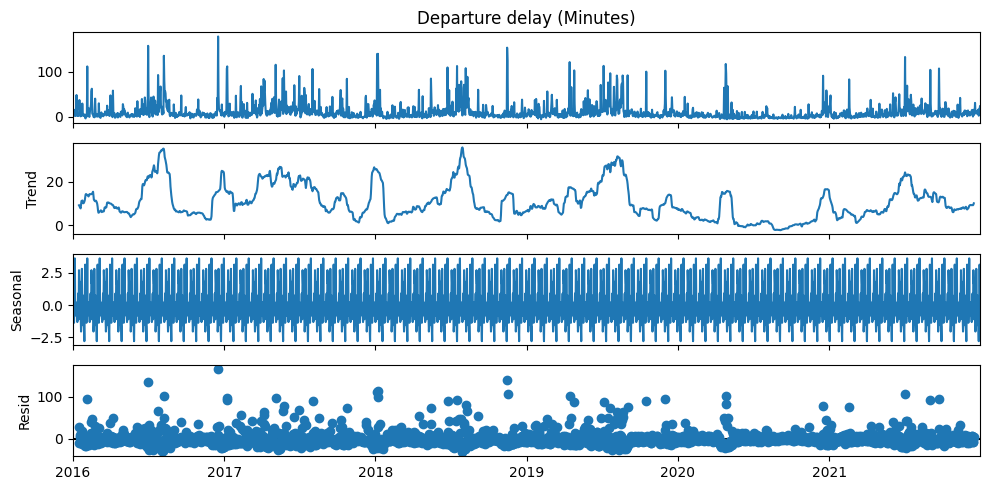

In [ ]:
# resample to daily average delay
daily_delay = flight['Departure delay (Minutes)'].resample('D').mean()

# decompose the time series
decomposition = seasonal_decompose(daily_delay, model='additive', period=30)

# plot the components
fig = decomposition.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()

Scatter Plot (Departure Delay Over 6 Years)

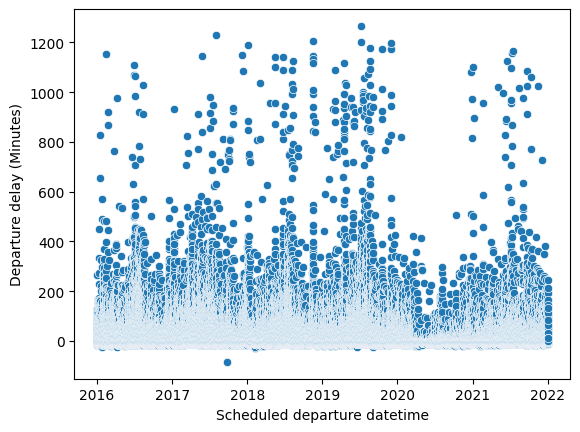

In [ ]:
sns.scatterplot(data=flight, x='Scheduled departure datetime', y='Departure delay (Minutes)')
plt.show()

Histogram Plot (Departure Delay)

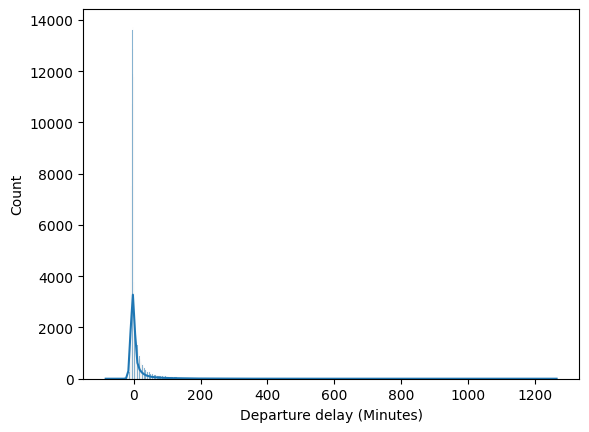

In [ ]:
sns.histplot(flight['Departure delay (Minutes)'], kde=True)
plt.show()

Histogram Plot (Departure Delay)

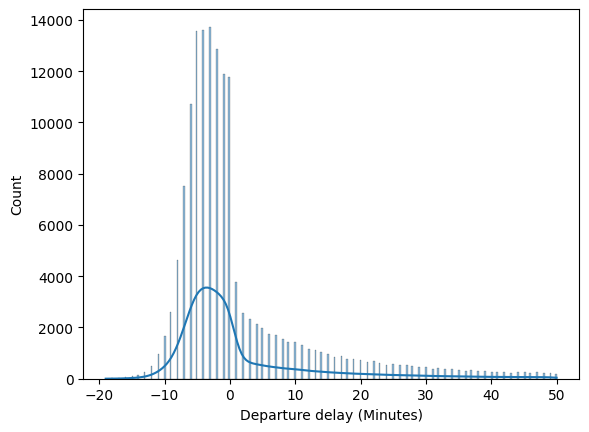

In [ ]:
sns.histplot(data=flight[(flight['Departure delay (Minutes)']>-20) & (flight['Departure delay (Minutes)']<=50)], x='Departure delay (Minutes)', kde=True)
plt.show()

**Data Preprocessing (Train and Test Data)**

1. Train-Test Split

* Split flight data chronologically, using the most recent 180 days for testing to simulate real-world forecasting, and the rest for training
* Combined a random sample of 20,000 non-delayed flights with all 26,029 delayed flights to maintain a more balanced training set

2. Feature Scaling

* Used StandardScaler to normalise the distributions of numerical weather features, to improve training convergence and prevent features with larger scales from dominating the model (air_temp, dew_temp, sea_level_pressure, wind_direction, wind_speed_rate, sky_condition, precip_1hour)
* Fit the scaler only on the training data to avoid data leakage, then applied it to the entire dataset for consistency

3. Categorical Encoding

* Used LabelEncoder to convert categorical identifiers into integer format (Flight Number, Tail Number, Destination Airport)

4. Weather Window Extraction

* Extracted a 5-hour weather sequence for each flight (starting from the floored hour of the scheduled departure time), to capture short-term weather trends prior to takeoff and provide the model with temporal context that may influence delay likelihood


In [ ]:
# split data chronologically
split_date = flight['Scheduled departure datetime'].dt.floor('h').max() - pd.Timedelta(days=180)
flight_train = flight[flight['Scheduled departure datetime'] < split_date].copy()
flight_test = flight[flight['Scheduled departure datetime'] >= split_date].copy()

In [ ]:
# count no. not_delayed and delayed flights in training set
not_delayed = flight_train[flight_train['Delayed']==0]
delayed = flight_train[flight_train['Delayed']==1]
print('No. Not Delayed Flights: ', len(not_delayed))
print('No. Delayed Flights: ', len(delayed))

No. Not Delayed Flights:  123173
No. Delayed Flights:  26029


In [ ]:
# create balanced training set
flight_train = pd.concat([not_delayed.sample(n=20000, random_state=42), delayed], ignore_index=True)

In [ ]:
scaling_cols = ['air_temp', 'dew_temp', 'sea_level_pressure', 'wind_direction', 'wind_speed_rate', 'sky_condition', 'precip_1hour']

# only fit scaler on training weather data
min_train_time = flight_train['Scheduled departure datetime'].dt.floor('h').min() - pd.Timedelta(hours=4)
max_train_time = flight_train['Scheduled departure datetime'].dt.floor('h').max()
weather_train = weather.loc[min_train_time:max_train_time]
scaler = StandardScaler()
scaler.fit(weather_train[scaling_cols])

# apply scaler to entire weather data
weather_scaled = weather.copy()
weather_scaled[scaling_cols] = scaler.transform(weather[scaling_cols])

In [ ]:
def extract_weather_windows_with_flight_data(flight, weather, window_size=5):
    X_weather = []
    X_flight = []
    y = []
    valid_flight_indices = []

    # fit label encoders for categorical features
    flight_number_enc = LabelEncoder().fit(flight['Flight Number'].astype(str))
    tail_number_enc = LabelEncoder().fit(flight['Tail Number'].astype(str))
    dest_airport_enc = LabelEncoder().fit(flight['Destination Airport'].astype(str))

    for idx, row in flight.iterrows():
        scheduled_departure_datetime = row['Scheduled departure datetime'].floor('h')
        departure_delay = row['Delayed']

        window_start = scheduled_departure_datetime - pd.Timedelta(hours=window_size - 1)
        window_end = scheduled_departure_datetime

        window = weather.loc[window_start:window_end]

        if len(window) == window_size:
            # extract weather window (5, num_weather_features)
            X_weather.append(window.values)

            # encode flight features
            flight_number = flight_number_enc.transform([str(row['Flight Number'])])[0]
            tail_number = tail_number_enc.transform([str(row['Tail Number'])])[0]
            dest_airport = dest_airport_enc.transform([str(row['Destination Airport'])])[0]

            flight_data = [flight_number, tail_number, dest_airport]
            X_flight.append(flight_data)

            y.append(departure_delay)
            valid_flight_indices.append(idx)

    return (
        np.array(X_weather),      # shape: (num_samples, 5, num_weather_features)
        np.array(X_flight),     # shape: (num_samples, num_flight_features)
        np.array(y),              # shape: (num_samples,)
        valid_flight_indices
    )

In [ ]:
# get arrays
X_train_weather, X_train_flight, y_train, train_indices = extract_weather_windows_with_flight_data(flight_train, weather_scaled)
X_test_weather, X_test_flight, y_test, test_indices = extract_weather_windows_with_flight_data(flight_test, weather_scaled)

In [ ]:
# check shape of arrays
print("X_train_weather shape:", X_train_weather.shape)
print("X_train_flight shape:", X_train_flight.shape)
print("y_train shape:", y_train.shape)
print("X_test_weather shape:", X_test_weather.shape)
print("X_test_flight shape:", X_test_flight.shape)
print("y_test shape:", y_test.shape)

X_train_weather shape: (46014, 5, 14)
X_train_flight shape: (46014, 3)
y_train shape: (46014,)
X_test_weather shape: (10549, 5, 14)
X_test_flight shape: (10549, 3)
y_test shape: (10549,)


In [ ]:
# convert arrays to tensors
X_train_weather_tensor = torch.tensor(X_train_weather, dtype=torch.float32)
X_train_flight_tensor = torch.tensor(X_train_flight, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_weather_tensor = torch.tensor(X_test_weather, dtype=torch.float32)
X_test_flight_tensor = torch.tensor(X_test_flight, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# combine tensors
train_dataset = TensorDataset(X_train_weather_tensor, X_train_flight_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_weather_tensor, X_test_flight_tensor, y_test_tensor)

# Model Training, Tuning and Evaluation

**LSTM**

In [ ]:
class LSTM_Model(torch.nn.Module):
    def __init__(self, input_size, flight_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.flight_fc = torch.nn.Linear(flight_size, 32)
        self.combined_fc = torch.nn.Linear(hidden_size + 32, 1)

    def forward(self, x_weather, x_flight):
        lstm_out, _ = self.lstm(x_weather)  # (batch, seq_len, hidden)
        lstm_out = lstm_out[:, -1, :]   # (batch, hidden)

        flight_out = torch.relu(self.flight_fc(x_flight))  # (batch, 32)

        combined = torch.cat([lstm_out, flight_out], dim=1)  # (batch, hidden + 32)
        out = self.combined_fc(combined)
        return out.squeeze(1)

In [ ]:
model = LSTM_Model(input_size=X_train_weather.shape[2], flight_size=X_train_flight.shape[1]).to('cuda')
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(test_dataset, batch_size=64)

for epoch in range(250):
    model.train()
    epoch_loss = 0
    for X_weather, X_flight, y_batch in train_loader:
        X_weather, X_flight, y_batch = X_weather.to('cuda'), X_flight.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        preds = model(X_weather, X_flight)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.9528
Epoch 2, Loss: 0.6809
Epoch 3, Loss: 0.6891
Epoch 4, Loss: 0.6619
Epoch 5, Loss: 0.6886
Epoch 6, Loss: 0.6548
Epoch 7, Loss: 0.6612
Epoch 8, Loss: 0.6656
Epoch 9, Loss: 0.6527
Epoch 10, Loss: 0.6432
Epoch 11, Loss: 0.6530
Epoch 12, Loss: 0.6564
Epoch 13, Loss: 0.6670
Epoch 14, Loss: 0.6306
Epoch 15, Loss: 0.6304
Epoch 16, Loss: 0.6265
Epoch 17, Loss: 0.6445
Epoch 18, Loss: 0.6223
Epoch 19, Loss: 0.6162
Epoch 20, Loss: 0.6174
Epoch 21, Loss: 0.6074
Epoch 22, Loss: 0.6031
Epoch 23, Loss: 0.6013
Epoch 24, Loss: 0.6029
Epoch 25, Loss: 0.5981
Epoch 26, Loss: 0.5874
Epoch 27, Loss: 0.5898
Epoch 28, Loss: 0.5948
Epoch 29, Loss: 0.5725
Epoch 30, Loss: 0.5850
Epoch 31, Loss: 0.5645
Epoch 32, Loss: 0.5667
Epoch 33, Loss: 0.5634
Epoch 34, Loss: 0.5565
Epoch 35, Loss: 0.5548
Epoch 36, Loss: 0.5450
Epoch 37, Loss: 0.5420
Epoch 38, Loss: 0.5427
Epoch 39, Loss: 0.5408
Epoch 40, Loss: 0.5340
Epoch 41, Loss: 0.5300
Epoch 42, Loss: 0.5245
Epoch 43, Loss: 0.5163
Epoch 44, Loss: 0.52

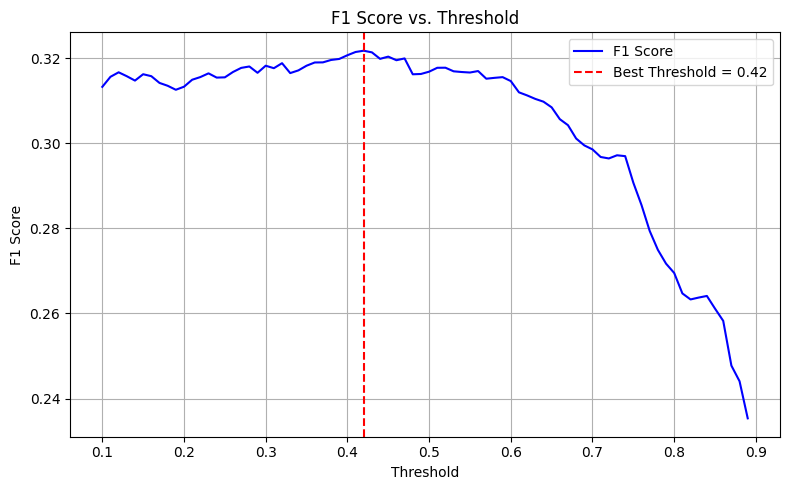

Best Threshold : 0.42
Test Accuracy  : 0.5703
Precision      : 0.2206
Recall         : 0.5943
F1 Score       : 0.3217
Confusion Matrix:
[[4941 3799]
 [ 734 1075]]


In [ ]:
model.eval()
y_probs = []

with torch.no_grad():
    for X_weather, X_flight, _ in test_loader:
        X_weather, X_flight = X_weather.to('cuda'), X_flight.to('cuda')
        logits = model(X_weather, X_flight)
        probs = torch.sigmoid(logits).squeeze().detach().cpu().numpy()
        y_probs.extend(probs)

y_probs = np.array(y_probs)

# threshold tuning
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    y_preds = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_preds, zero_division=0)
    f1_scores.append(f1)

# find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

# plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1 Score", color='blue')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# final metrics using best threshold
y_preds = (y_probs >= best_threshold).astype(int)
accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, zero_division=0)
recall = recall_score(y_test, y_preds, zero_division=0)
cm = confusion_matrix(y_test, y_preds)

print(f"Best Threshold : {best_threshold:.2f}")
print(f"Test Accuracy  : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {best_f1:.4f}")
print("Confusion Matrix:")
print(cm)

**XGBoost**

In [ ]:
# flatten (5 timesteps * num_features) into a single vector
X_train_flat = X_train_weather.reshape(X_train_weather.shape[0], -1)
X_test_flat = X_test_weather.reshape(X_test_weather.shape[0], -1)

X_train_combined = np.hstack([X_train_flat, X_train_flight])
X_test_combined = np.hstack([X_test_flat, X_test_flight])

In [ ]:
model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=500,
    max_depth = 10
)

model.fit(X_train_combined, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

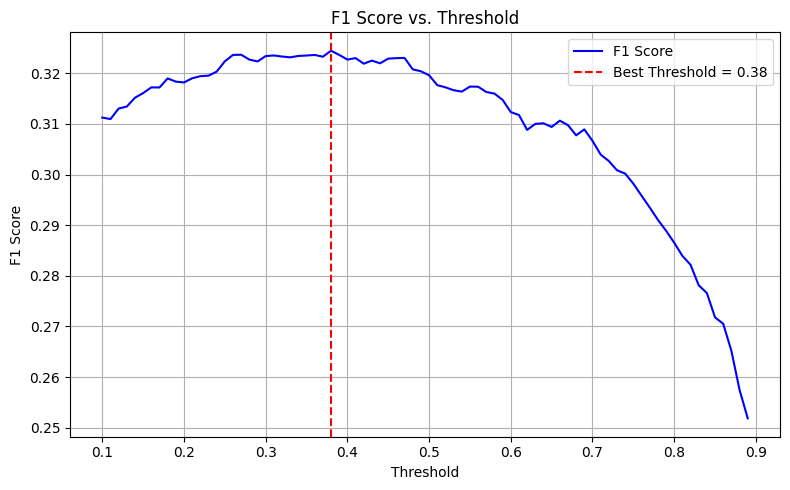

Best Threshold : 0.38
Test Accuracy  : 0.5619
Precision      : 0.2205
Recall         : 0.6136
F1 Score       : 0.3245
Confusion Matrix:
[[4817 3923]
 [ 699 1110]]


In [ ]:
# predict probabilities
y_probs = model.predict_proba(X_test_combined)[:, 1]

# threshold tuning
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for t in thresholds:
    y_preds = (y_probs >= t).astype(int)
    f1 = f1_score(y_test, y_preds, zero_division=0)
    f1_scores.append(f1)

# find the best threshold
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
best_f1 = f1_scores[best_index]

# plot
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label="F1 Score", color='blue')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# final metrics using best threshold
y_preds = (y_probs >= best_threshold).astype(int)
accuracy = accuracy_score(y_test, y_preds)
precision = precision_score(y_test, y_preds, zero_division=0)
recall = recall_score(y_test, y_preds, zero_division=0)
cm = confusion_matrix(y_test, y_preds)

print(f"Best Threshold : {best_threshold:.2f}")
print(f"Test Accuracy  : {accuracy:.4f}")
print(f"Precision      : {precision:.4f}")
print(f"Recall         : {recall:.4f}")
print(f"F1 Score       : {best_f1:.4f}")
print("Confusion Matrix:")
print(cm)

Both the LSTM model (using 5-hour weather sequences) and the XGBoost model (trained on the same sequences flattened into fixed-length vectors) achieved similar performance, with F1-scores of approximately 0.32. This outcome indicates that temporal dependencies within the 5-hour weather window may not be a significant factor in predicting delays, or that the models were unable to extract such patterns effectively. Additionally, the relatively low F1-score points to a need for more informative features, as the basic weather and flight features alone may be insufficient to capture the complexity of flight delay causation.

Potential areas for improvement include extending the time window, incorporating additional flight-level and operational features (e.g., airport congestion, airline schedules, prior flight delays), and further tuning of model architectures and preprocessing strategies.